# Detecting Sperm Motility using 3D Convolutional Networks
#### Submission for Innerve Data Hackathon, 2020

* **Domain**: Healthcare
* **Dataset**: [The Visem Dataset](https://datasets.simula.no/visem/), a multimodal video dataset of human spermatozoa.

**Authors**: Priyansi, Biswaroop Bhattacharjee, Junaid Rahim

This notebook contains detailed EDA on the Visem dataset the methods used to select the relevant features


## Introduction

Semen analysis is an integral part of Invitro Fertilization also known as IVF. Traditional methods of
semen analysis in IVF consist of manual methods or heavy machines that cost a lot. Also, the results
from these machines depend on the consistency of the sample which is subject to change with time or human
error (mishandling in the lab).

These analyses help fertility doctors understand the quality of the semen using factors like 
* Sperm motility 
* Sperm morphology
* Sperm vitality. 

The usual parameters taken into consideration are semen volume, sperm concentration, total sperm count, age, BMI etc. 
There is a need for a cheaper and more consistent method to do sperm analysis. There has been research that shows
that convolutional neural networks can be used on microscopic videos of sperms to predict motility, morphology and vitality. 

In this project, we trained a spatial temporal 3D convolutional neural network to predict sperm motility from videos along
with other tabular data. We are using 3D CNNs because time is a factor in analysing these video images, we are including time
as a third dimension


## Dataset Details

We make use of the [visem](https://datasets.simula.no/visem/) dataset. It consists of 35 GB of tabular
and video data collected from 85 participants. The tabular data consists of levels of various serums in the sample, quantitative data
like semen volume, sperm count and concentration etc. as well as participant data like Abstinence time(days), BMI, Age etc.

The videos are microscopic videos of sperms, each video is around 5 to 7 minutes long and has an average size of 700mb.
A sample image is attached for reference 

<div align="center">
    <img width="50%" src="https://datasets.simula.no/visem/images/sperm-sample.png" />
</div>

This notebook has the code to perform EDA on the tabular data, we have identified some of the prominent 
features of the tabular data that has strong statistical and scientific correlation with the classes
we want to predict.


In [50]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [54]:
import os
os.chdir("/gdrive/My Drive/Hackathons/Innerve 2020/visem-dataset/dataset")

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

### Importing all the CSV files and converting them to dataframes

1. `fatty_acids_serum.csv`
2. `fatty_acids_spermatoza.csv`
3. `participant_related_data.csv`
4. `semen_analysis_data.csv`
5. `sex_hormones.csv`
6. `videos.csv`

In [56]:
fatty_acids_serum_df = pd.read_csv("fatty_acids_serum.csv", delimiter=";", index_col = "ID")
fatty_acids_spermatoza_df = pd.read_csv("fatty_acids_spermatoza.csv", delimiter=";", index_col = "ID")
participant_related_data_df = pd.read_csv("participant_related_data.csv", delimiter = ";", decimal = ",", index_col = "ID")
semen_analysis_df = pd.read_csv("semen_analysis_data.csv", delimiter=";", decimal = ",", index_col = "ID")
sex_hormones_df = pd.read_csv("sex_hormones.csv", delimiter = ";", decimal = ",", index_col = "ID")
video_data_df = pd.read_csv("videos.csv", delimiter = ";", decimal = ",", index_col = "ID")

In [57]:
# Fixing missing "Abstinence time(days)" column in participant_related_data_df

participant_related_data_df["Abstinence time(days)"] = [x.strip().replace(",", ".").replace("Not reported", "-1") for x in participant_related_data_df["Abstinence time(days)"]]
participant_related_data_df["Abstinence time(days)"] = participant_related_data_df["Abstinence time(days)"].astype(float)
median_abstinence = participant_related_data_df["Abstinence time(days)"].median()

for x in participant_related_data_df["Abstinence time(days)"]:
    if(x == "-1"):
        x = median_abstinence

In [58]:
# Conversion in fatty_acids_serum_df
for i in fatty_acids_serum_df.columns:
    fatty_acids_serum_df[i] = fatty_acids_serum_df[i].apply(lambda x: x.replace(',', '.'))
    fatty_acids_serum_df[i] = fatty_acids_serum_df[i].apply(lambda x: float(x))

# Conversion in fatty_acids_spermatoza_df
for i in fatty_acids_spermatoza_df.columns:
    fatty_acids_spermatoza_df[i] = fatty_acids_spermatoza_df[i].apply(lambda x: x.replace(',', '.'))
    fatty_acids_spermatoza_df[i] = fatty_acids_spermatoza_df[i].apply(lambda x: float(x))

### Overall features and size of all dataframes

Fatty Acids Serum Data

In [59]:
fatty_acids_serum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 15 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Serum C14:0 (myristic acid)                    85 non-null     float64
 1   Serum C16:0 (palmitic acid)                    85 non-null     float64
 2   Serum C16:1 (palmitoleic acid)                 85 non-null     float64
 3   Serum C18:0 (stearic acid)                     85 non-null     float64
 4   Serum C18:1 n-9 (oleic acid)                   85 non-null     float64
 5   Serum total C18:1                              85 non-null     float64
 6   Serum C18:2 n-6 (linoleic acid, LA)            85 non-null     float64
 7   Serum C18:3 n-6 (gamma-linoleic acid, GLA)     85 non-null     float64
 8   Serum C20:1 n-9                                85 non-null     float64
 9   Serum C20:2 n-6                                85 non-nu

In [60]:
fatty_acids_serum_df.head()

Serum C14:0 (myristic acid)  ...  Serum C22:6 n-3 (docosahexaenoic acid, DHA)
ID                               ...                                             
1                          0.36  ...                                         5.53
2                          0.28  ...                                         6.31
3                          0.36  ...                                         6.34
4                          0.32  ...                                         3.23
5                          0.40  ...                                         4.31

[5 rows x 15 columns]

Fatty Acids Spermatoza Data

In [61]:
fatty_acids_spermatoza_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Sperm C14:0 (myristic acid)                   85 non-null     float64
 1   Sperm C15:0 (pentadecanoic acid)              85 non-null     float64
 2   Sperm C16:0 (palmitic acid)                   85 non-null     float64
 3   Sperm C16:1 n-7 (palmitoleic acid)            85 non-null     float64
 4   Sperm C17:0                                   85 non-null     float64
 5   Sperm C18:0 (stearic acid)                    85 non-null     float64
 6   Sperm C18:1 trans n-6 to n-11                 85 non-null     float64
 7   Sperm C18:1 n-9 (oleic acid)                  85 non-null     float64
 8   Sperm C18:1 n-7 to n-11                       85 non-null     float64
 9   Sperm C18:2 n-6 (Linoleic acid, LA)           85 non-null     float

In [62]:
fatty_acids_spermatoza_df.head()

Sperm C14:0 (myristic acid)  ...  Sperm C22:6,n3 (docosahexaenoic acid, DHA)
ID                               ...                                            
1                           1.3  ...                                        25.3
2                           1.5  ...                                        17.3
3                           1.1  ...                                        21.5
4                           1.1  ...                                        14.8
5                           1.1  ...                                        26.6

[5 rows x 23 columns]

Participant Related Data

In [63]:
participant_related_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Abstinence time(days)    85 non-null     float64
 1   Body mass index (kg/m²)  85 non-null     float64
 2   Age (years)              85 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [64]:
participant_related_data_df.head()

Abstinence time(days)  Body mass index (kg/m²)  Age (years)
ID                                                             
1                     4.0                     32.5           36
2                     4.0                     33.7           61
3                     2.0                     62.7           51
4                     2.5                     45.5           38
5                     3.0                     51.0           33

Semen Analysis Data

In [65]:
semen_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Sperm concentration (x10⁶/mL)       85 non-null     float64
 1   Total sperm count (x10⁶)            85 non-null     float64
 2   Ejaculate volume (mL)               85 non-null     float64
 3   Sperm vitality (%)                  85 non-null     int64  
 4   Normal spermatozoa (%)              85 non-null     float64
 5   Head defects (%)                    85 non-null     float64
 6   Midpiece and neck defects (%)       85 non-null     float64
 7   Tail defects (%)                    85 non-null     float64
 8   Cytoplasmic droplet (%)             85 non-null     float64
 9   Teratozoospermia index              85 non-null     float64
 10  Progressive motility (%)            85 non-null     int64  
 11  Non progressive sperm motility (%)  85 non-null

In [66]:
semen_analysis_df.head()

Sperm concentration (x10⁶/mL)  ...  DNA fragmentation index, DFI (%)
ID                                 ...                                  
1                           105.3  ...                                29
2                            45.4  ...                                57
3                            50.0  ...                                12
4                            42.9  ...                                15
5                            32.8  ...                                13

[5 rows x 15 columns]

Sex Hormones Data

In [67]:
sex_hormones_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Seminal plasma anti-Müllerian hormone (AMH) (pmol/L)  85 non-null     int64  
 1   Serum total testosterone (nmol/L)                     85 non-null     float64
 2   Serum oestradiol (nmol/L)                             85 non-null     float64
 3   Serum sex hormone-binding globulin, SHBG (nmol/L)     85 non-null     int64  
 4   Serum follicle-stimulating hormone, FSH (IU/L)        85 non-null     float64
 5   Serum Luteinizing hormone, LH (IU/L)                  85 non-null     float64
 6   Serum inhibin B (ng/L)                                85 non-null     int64  
 7   Serum anti-Müllerian hormone, AMH (pmol/L)            85 non-null     int64  
dtypes: float64(4), int64(4)
memory usage: 6.0 KB


In [68]:
sex_hormones_df.head()

Seminal plasma anti-Müllerian hormone (AMH) (pmol/L)  ...  Serum anti-Müllerian hormone, AMH (pmol/L)
ID                                                        ...                                            
1                                                  64     ...                                          54
2                                                 423     ...                                          19
3                                                  37     ...                                          47
4                                                 257     ...                                          29
5                                                2203     ...                                          68

[5 rows x 8 columns]

Video Data

In [69]:
video_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   video   85 non-null     object
dtypes: object(1)
memory usage: 1.3+ KB


In [70]:
video_data_df.head()

video
ID                                   
1                  1_09.09.02_SSW.avi
2   2_09.09.03_lots of debris_SSW.avi
3                  3_11.01.21_JMA.avi
4                   4_11.03.29_HH.avi
5                  5_11.05.04_JMA.avi

### Combining all dataframes together as `final_df`

In [ ]:
final_df = sex_hormones_df.copy()

all_df = [
    fatty_acids_serum_df, 
    fatty_acids_spermatoza_df,
    participant_related_data_df,
    semen_analysis_df,
    video_data_df
]

for df in all_df:
    final_df = pd.merge(final_df, df, on='ID')

In [74]:
final_df.shape

(85, 65)

In [75]:
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 65 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Seminal plasma anti-Müllerian hormone (AMH) (pmol/L)  85 non-null     int64  
 1   Serum total testosterone (nmol/L)                     85 non-null     float64
 2   Serum oestradiol (nmol/L)                             85 non-null     float64
 3   Serum sex hormone-binding globulin, SHBG (nmol/L)     85 non-null     int64  
 4   Serum follicle-stimulating hormone, FSH (IU/L)        85 non-null     float64
 5   Serum Luteinizing hormone, LH (IU/L)                  85 non-null     float64
 6   Serum inhibin B (ng/L)                                85 non-null     int64  
 7   Serum anti-Müllerian hormone, AMH (pmol/L)            85 non-null     int64  
 8   Serum C14:0 (myristic acid)                           85 non-n

## Scatter plots of important features

These features were identified from articles on semen analysis and personal correspondance with 

[Dr. Sukla Das](mailto:mailsukladas@gmail.com), Pathologist (Fertility Specialist), Guwhati



In [78]:
def plot_feature_against_motility(feature_name):
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.suptitle(f"{feature_name} Vs Progressive motility (%), Non progressive sperm motility (%), Immotile sperm (%)")
    ax[0].scatter(final_df[feature_name], final_df["Progressive motility (%)"])
    ax[1].scatter(final_df[feature_name], final_df["Non progressive sperm motility (%)"])
    ax[2].scatter(final_df[feature_name], final_df["Immotile sperm (%)"])
    
    ax[0].set_xlabel(feature_name)
    ax[1].set_xlabel(feature_name)
    ax[2].set_xlabel(feature_name)

    ax[0].set_ylabel("Progressive motility (%)")
    ax[1].set_ylabel("Non progressive sperm motility (%)")
    ax[2].set_ylabel("Immotile sperm (%)")

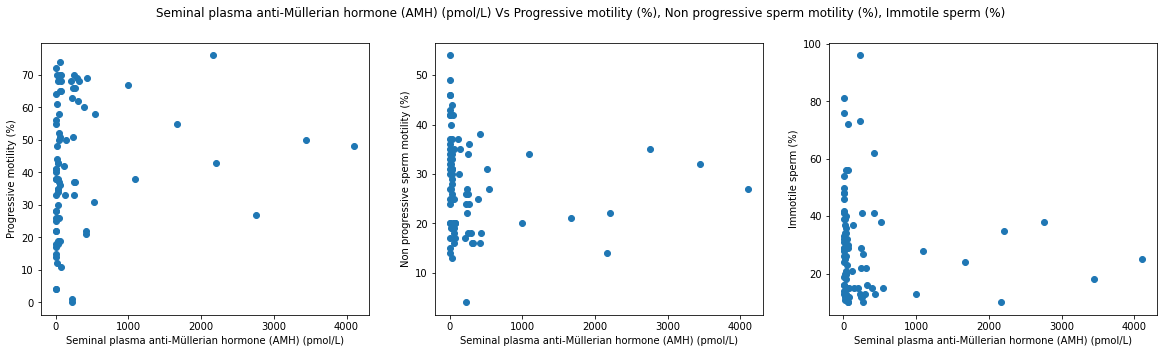

In [79]:
plot_feature_against_motility("Seminal plasma anti-Müllerian hormone (AMH) (pmol/L)")

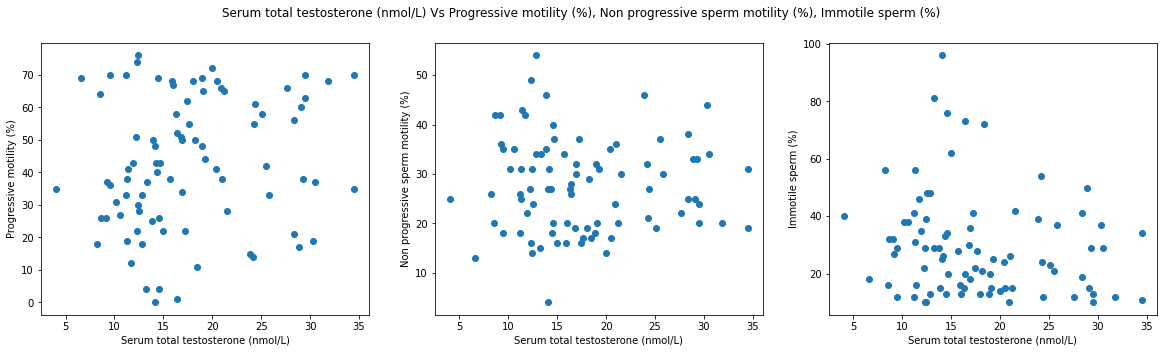

In [80]:
plot_feature_against_motility("Serum total testosterone (nmol/L)")

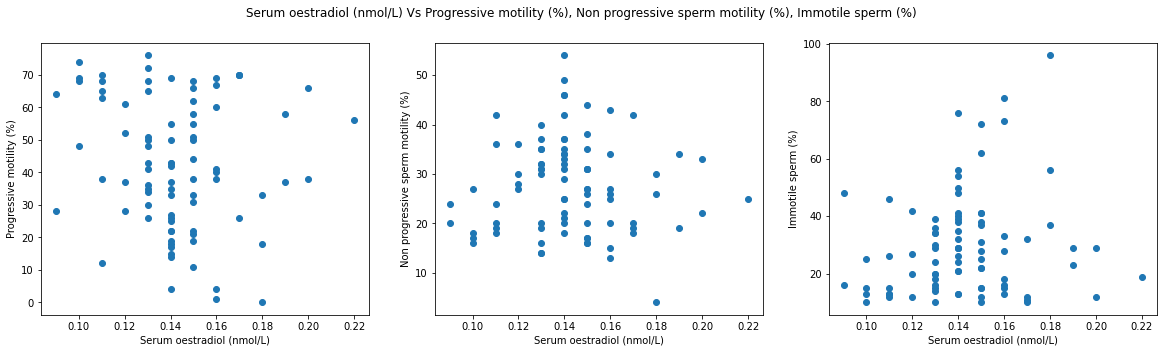

In [81]:
plot_feature_against_motility("Serum oestradiol (nmol/L)")

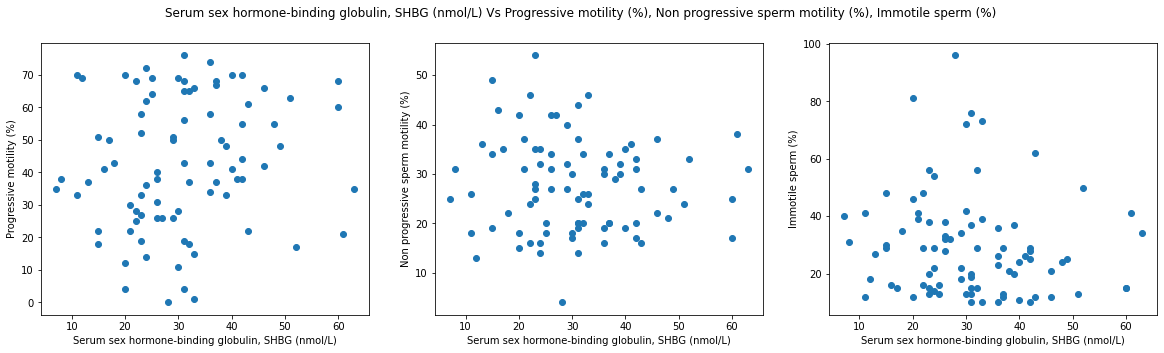

In [82]:
plot_feature_against_motility("Serum sex hormone-binding globulin, SHBG (nmol/L)")

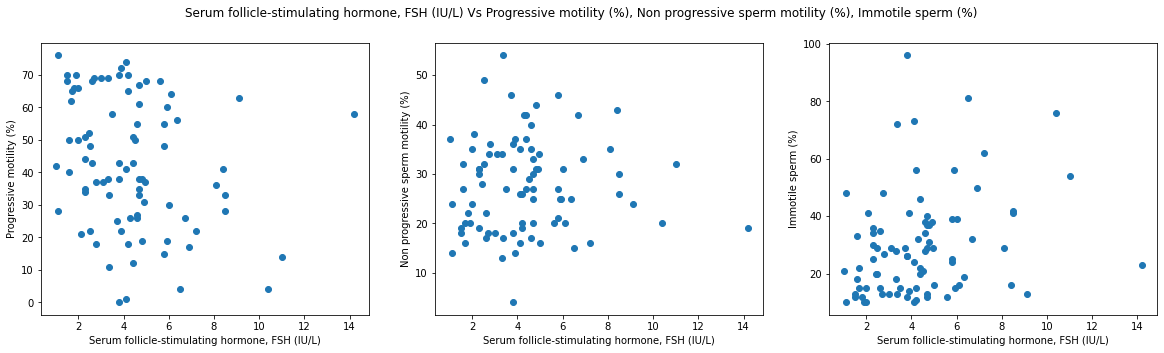

In [83]:
plot_feature_against_motility("Serum follicle-stimulating hormone, FSH (IU/L)")

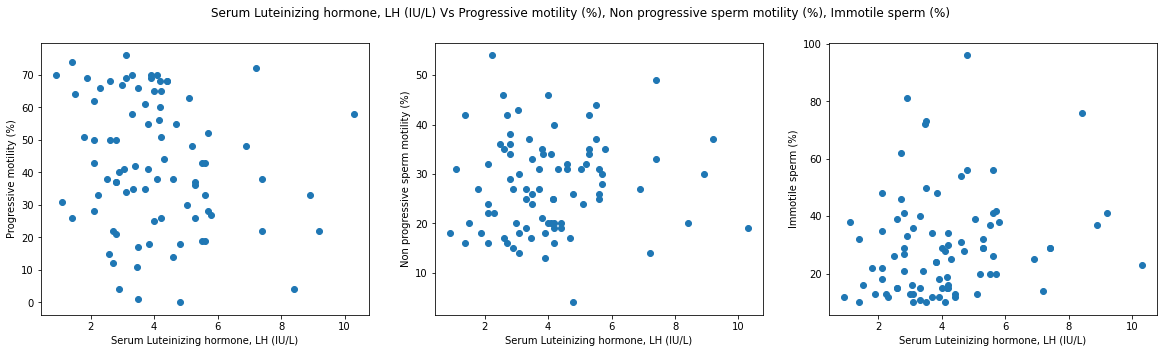

In [84]:
plot_feature_against_motility("Serum Luteinizing hormone, LH (IU/L)")

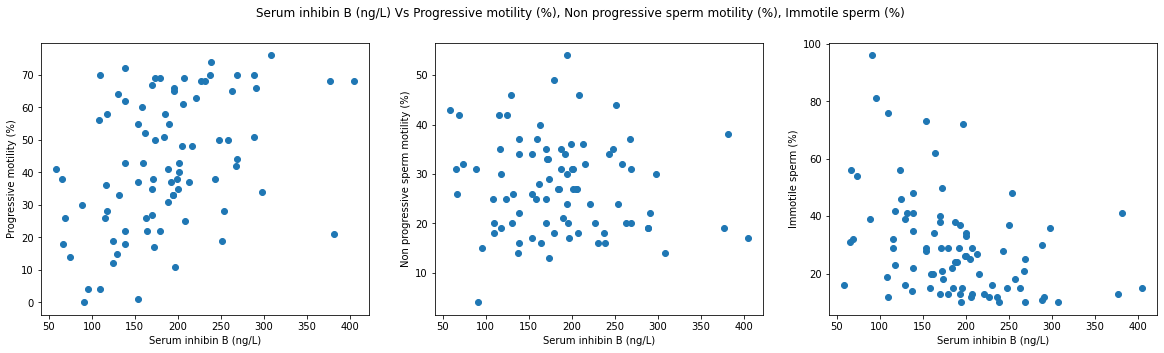

In [85]:
plot_feature_against_motility("Serum inhibin B (ng/L)")

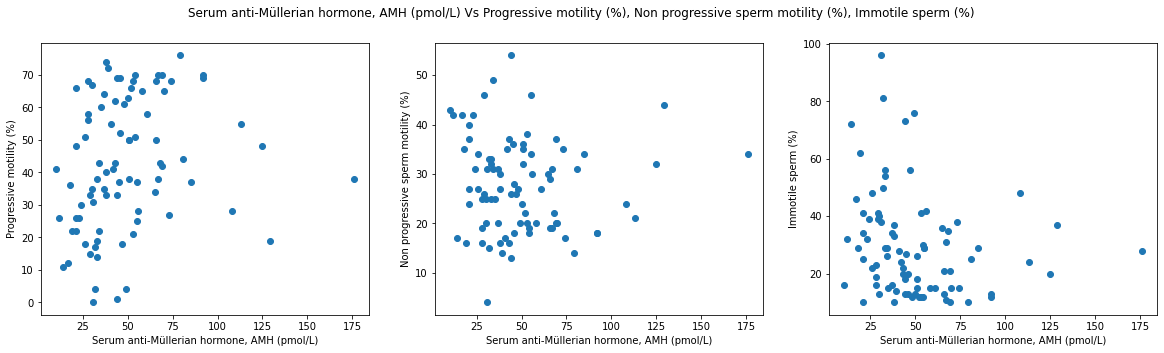

In [86]:
plot_feature_against_motility("Serum anti-Müllerian hormone, AMH (pmol/L)")

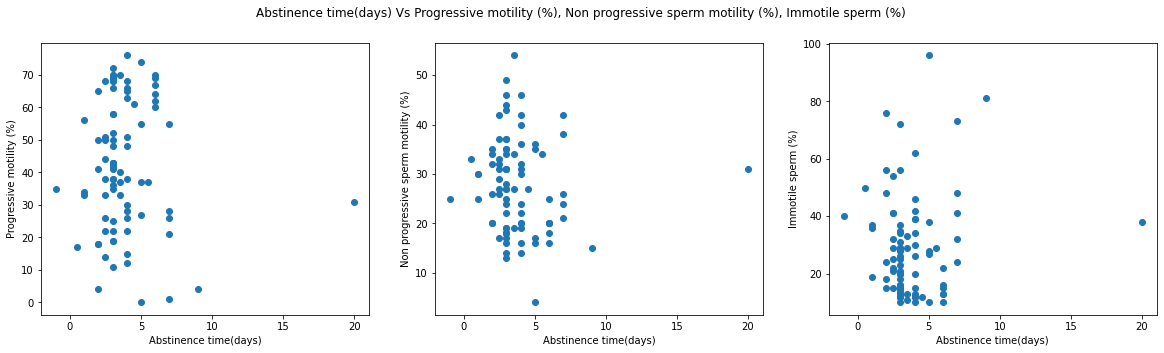

In [87]:
plot_feature_against_motility("Abstinence time(days)")

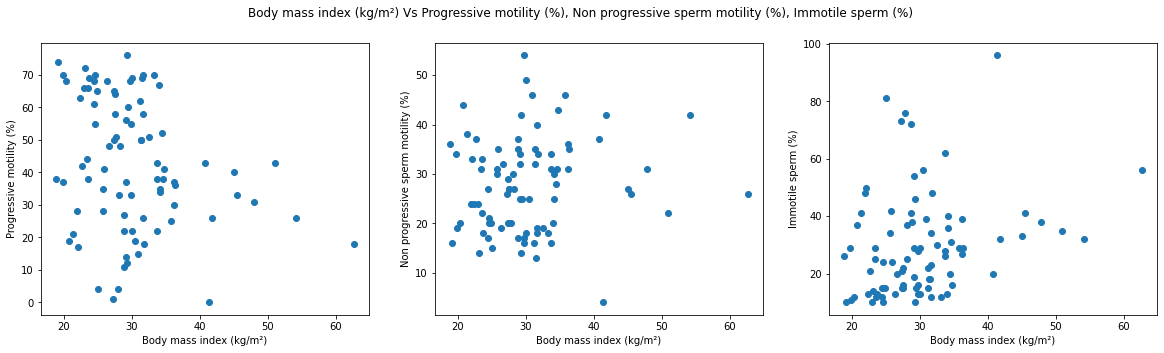

In [88]:
plot_feature_against_motility("Body mass index (kg/m²)")

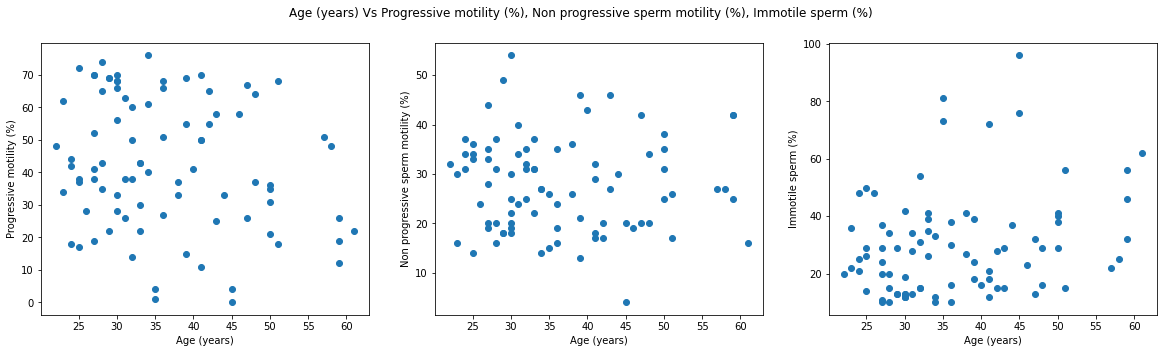

In [89]:
plot_feature_against_motility("Age (years)")

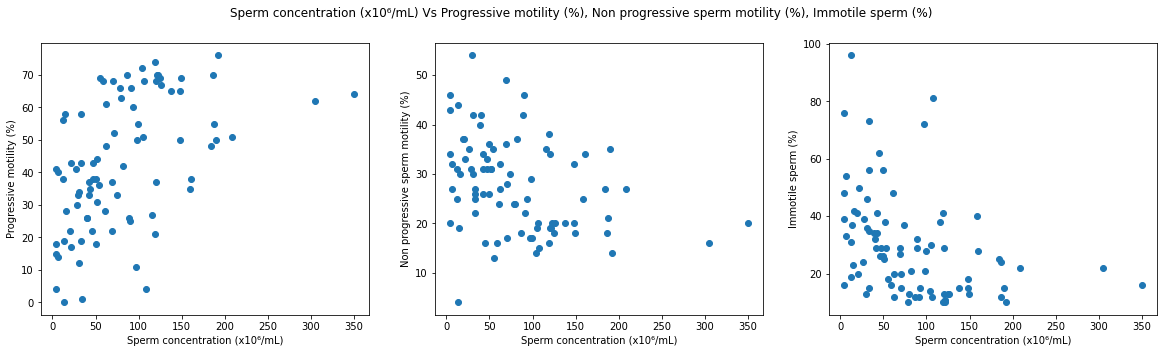

In [90]:
plot_feature_against_motility("Sperm concentration (x10⁶/mL)")

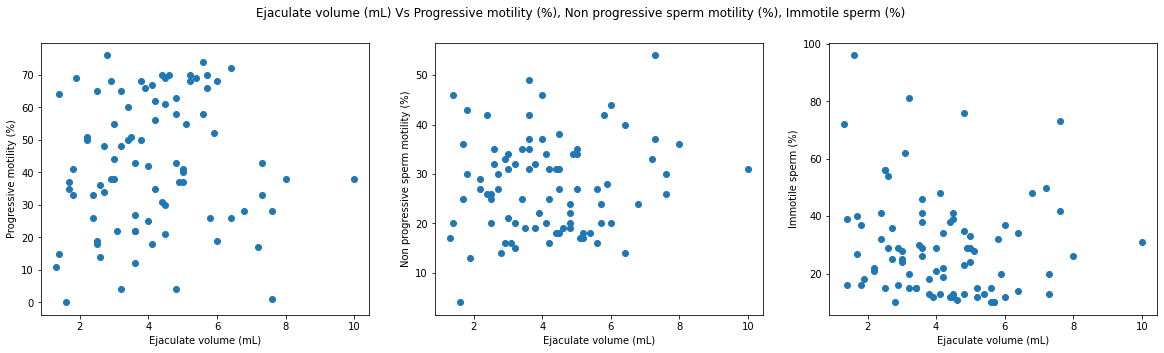

In [91]:
plot_feature_against_motility("Ejaculate volume (mL)")

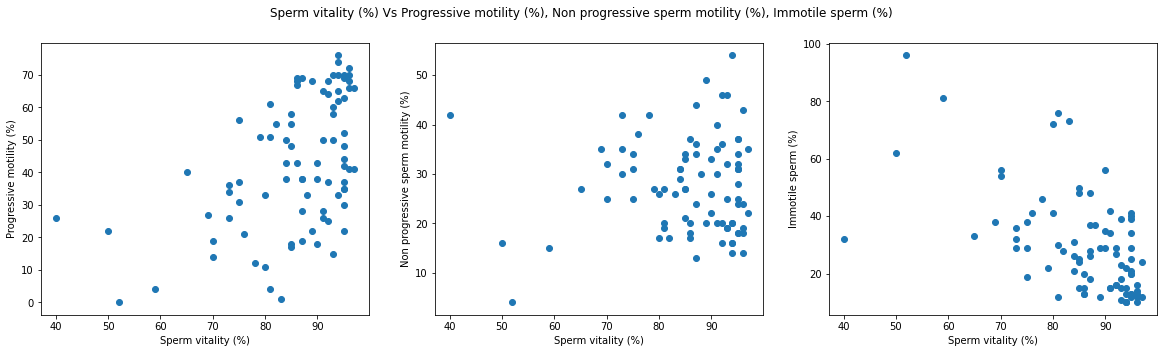

In [92]:
plot_feature_against_motility("Sperm vitality (%)")

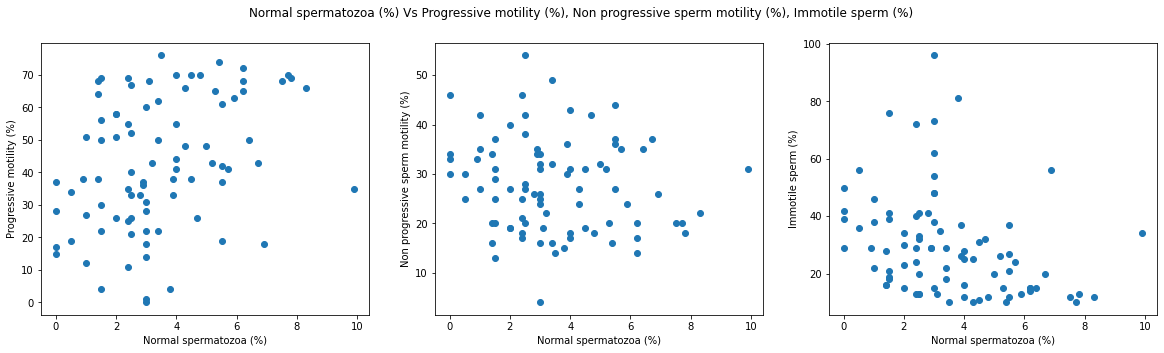

In [93]:
plot_feature_against_motility("Normal spermatozoa (%)")

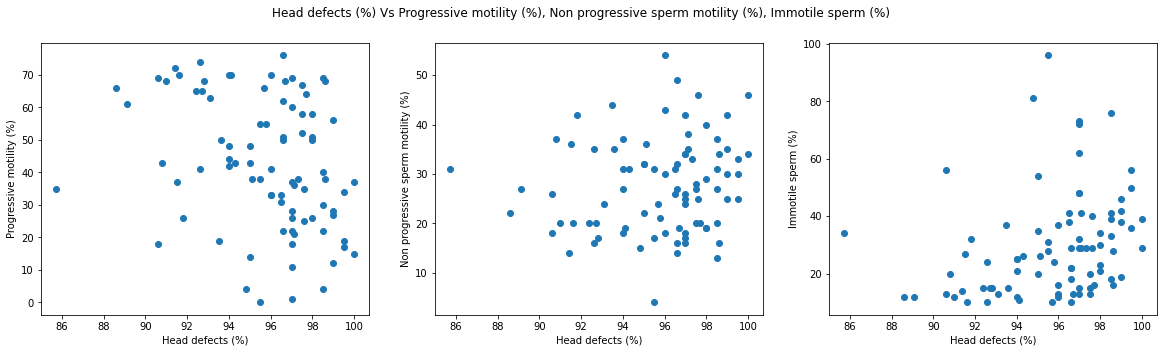

In [94]:
plot_feature_against_motility("Head defects (%)")

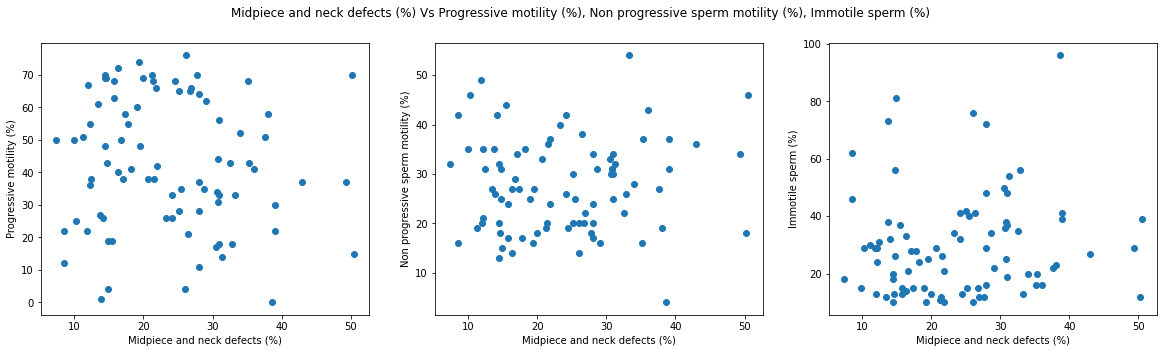

In [95]:
plot_feature_against_motility("Midpiece and neck defects (%)")

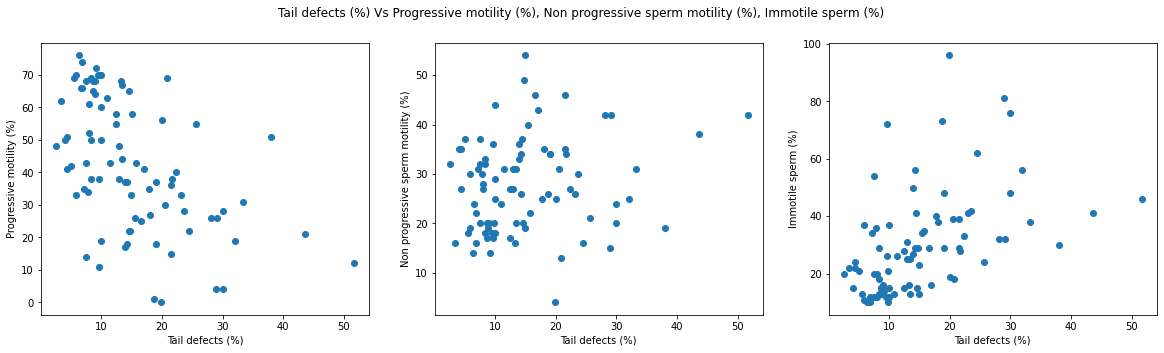

In [96]:
plot_feature_against_motility("Tail defects (%)")

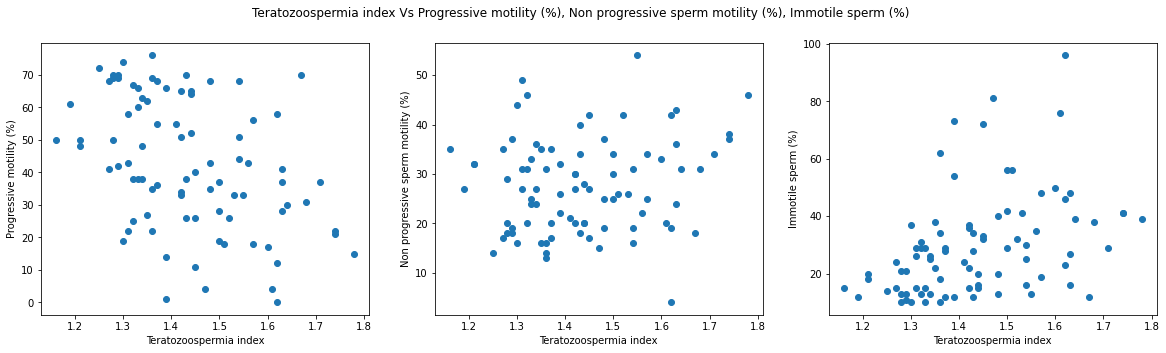

In [97]:
plot_feature_against_motility("Teratozoospermia index")

### Correlation matrix of all important features

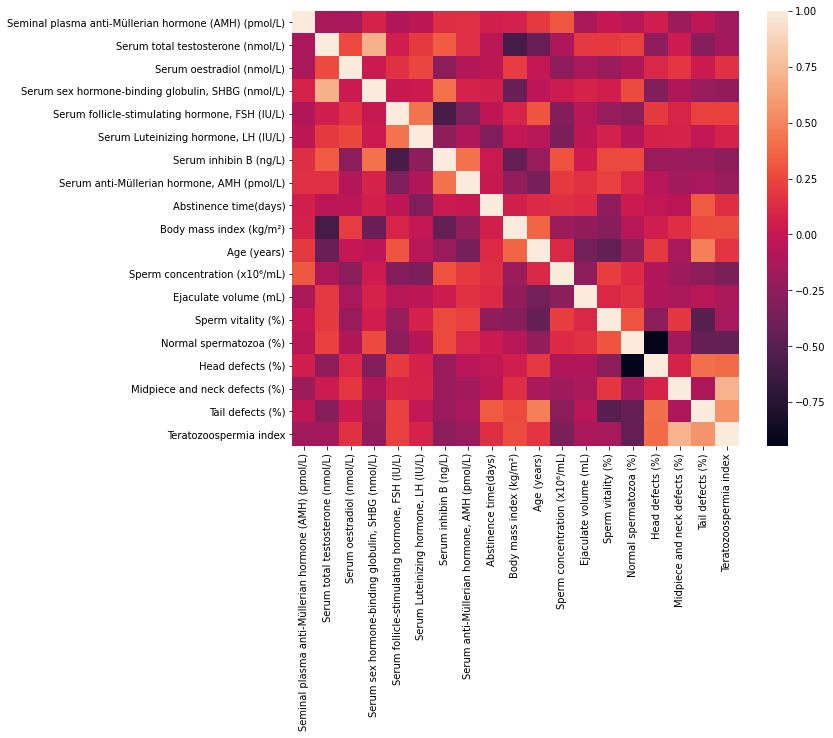

In [98]:
imp_features = [            
    "Seminal plasma anti-Müllerian hormone (AMH) (pmol/L)",
    "Serum total testosterone (nmol/L)",
    "Serum oestradiol (nmol/L)",
    "Serum sex hormone-binding globulin, SHBG (nmol/L)",
    "Serum follicle-stimulating hormone, FSH (IU/L)",
    "Serum Luteinizing hormone, LH (IU/L)",
    "Serum inhibin B (ng/L)",
    "Serum anti-Müllerian hormone, AMH (pmol/L)",
    "Abstinence time(days)",
    "Body mass index (kg/m²)",
    "Age (years)",
    "Sperm concentration (x10⁶/mL)",
    "Ejaculate volume (mL)",
    "Sperm vitality (%)",
    "Normal spermatozoa (%)",
    "Head defects (%)",
    "Midpiece and neck defects (%)",
    "Tail defects (%)",
    "Teratozoospermia index"
]

important_df = final_df[imp_features]

plt.figure(figsize=(10,8))
corrMatrix = important_df.corr()
sn.heatmap(corrMatrix)
plt.show()

## Distribution of Progressive motility (%), Non progressive sperm motility (%) and Immotile sperm (%)

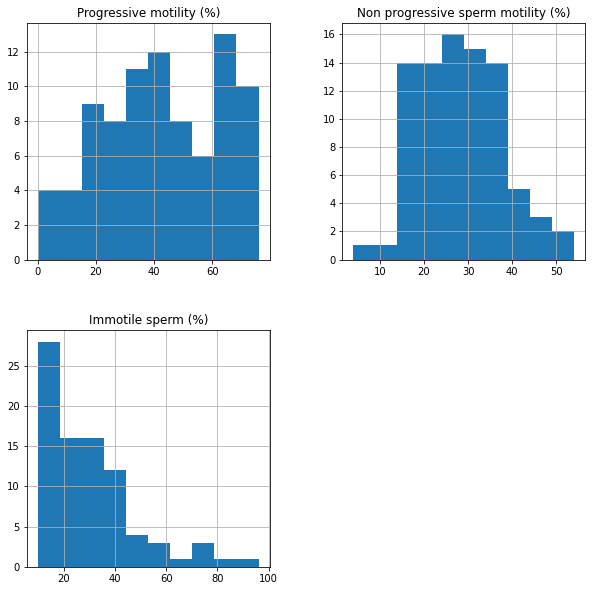

In [99]:
final_df[["Progressive motility (%)", "Non progressive sperm motility (%)", "Immotile sperm (%)"]].hist(figsize=(10,10))
plt.show()